In [ ]:
!pip install librosa kagglehub soundfile matplotlib numpy scikit-learn

In [ ]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import kagglehub

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
path = kagglehub.dataset_download(
    "uwrfkaggler/ravdess-emotional-speech-audio"
)

print("Dataset path:", path)

Using Colab cache for faster access to the 'ravdess-emotional-speech-audio' dataset.
Dataset path: /kaggle/input/ravdess-emotional-speech-audio


In [ ]:
audio_files = []

for root, _, files in os.walk(path):
    for file in files:
        if file.endswith(".wav"):
            audio_files.append(os.path.join(root, file))

print("Total audio samples:", len(audio_files))

Total audio samples: 2880


In [ ]:
emotion_dict = {
    "01":"neutral","02":"calm","03":"happy","04":"sad",
    "05":"angry","06":"fearful","07":"disgust","08":"surprised"
}

stress_map = {
    "angry":"stress",
    "fearful":"stress",
    "sad":"stress",
    "disgust":"stress",
    "surprised":"stress",
    "happy":"normal",
    "calm":"normal",
    "neutral":"normal"
}

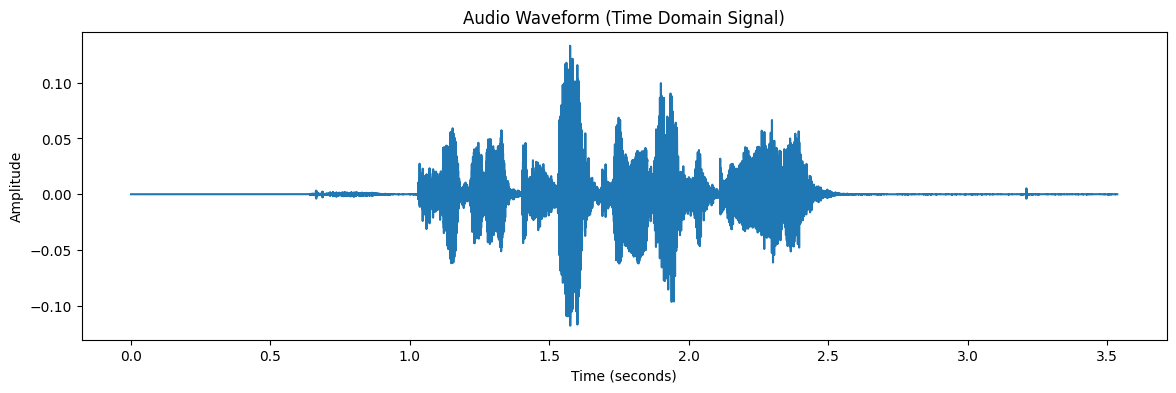

In [ ]:
# -------- Waveform Visualization --------

sample_audio = audio_files[0]

# Load audio
signal, sr = librosa.load(sample_audio, sr=None)

# Create time axis
time_axis = np.linspace(0, len(signal)/sr, num=len(signal))

# Plot waveform
plt.figure(figsize=(14,4))
plt.plot(time_axis, signal)
plt.title("Audio Waveform (Time Domain Signal)")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.show()

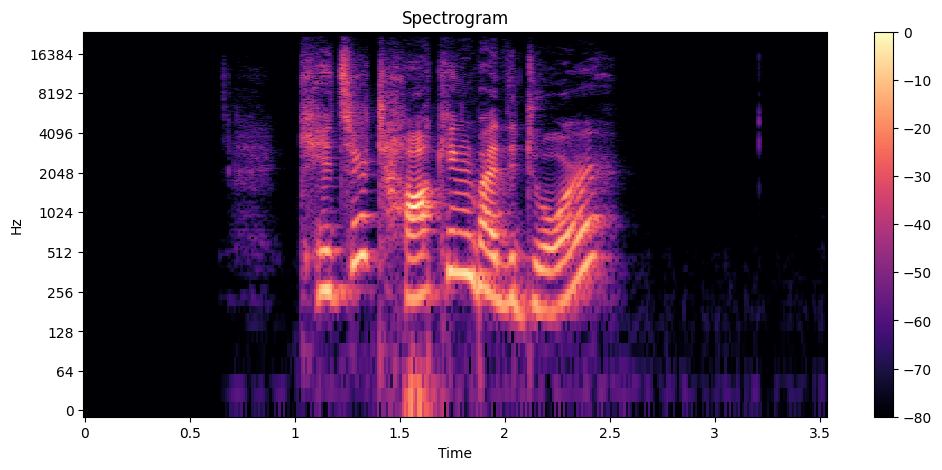

In [ ]:
sample_audio = audio_files[0]
signal, sr = librosa.load(sample_audio, sr=None)

# framing + windowing via STFT
stft = librosa.stft(signal, n_fft=2048, hop_length=512)
spectrogram_db = librosa.amplitude_to_db(np.abs(stft), ref=np.max)

plt.figure(figsize=(12,5))
librosa.display.specshow(spectrogram_db, sr=sr,
                         x_axis='time', y_axis='log')
plt.title("Spectrogram")
plt.colorbar()
plt.show()

In [ ]:
def extract_features(file_path):

    signal, sr = librosa.load(file_path, sr=None)

    # MFCC
    mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=13)
    mfcc_mean = np.mean(mfcc.T, axis=0)

    # Zero Crossing Rate
    zcr = np.mean(librosa.feature.zero_crossing_rate(signal))

    # Spectral Centroid
    centroid = np.mean(librosa.feature.spectral_centroid(y=signal, sr=sr))

    # Energy (RMS)
    energy = np.mean(librosa.feature.rms(y=signal))

    # Pitch (autocorrelation approximation)
    pitches, magnitudes = librosa.piptrack(y=signal, sr=sr)
    pitch = np.mean(pitches[pitches > 0])

    # Emotion label extraction
    filename = os.path.basename(file_path)
    emotion_code = filename.split("-")[2]
    emotion = emotion_dict[emotion_code]
    label = stress_map[emotion]

    feature_vector = np.hstack([
        mfcc_mean, zcr, centroid, energy, pitch
    ])

    return feature_vector, label, mfcc

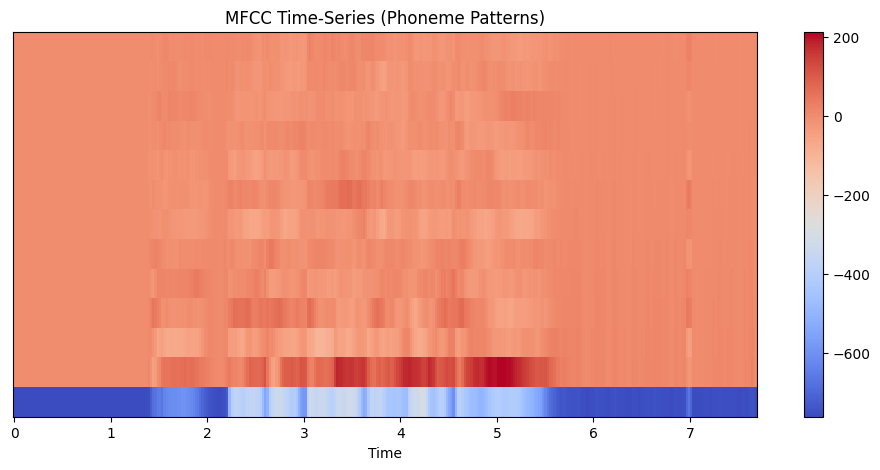

In [ ]:
features, label, mfcc_series = extract_features(audio_files[0])

plt.figure(figsize=(12,5))
librosa.display.specshow(mfcc_series, x_axis='time')
plt.title("MFCC Time-Series (Phoneme Patterns)")
plt.colorbar()
plt.show()

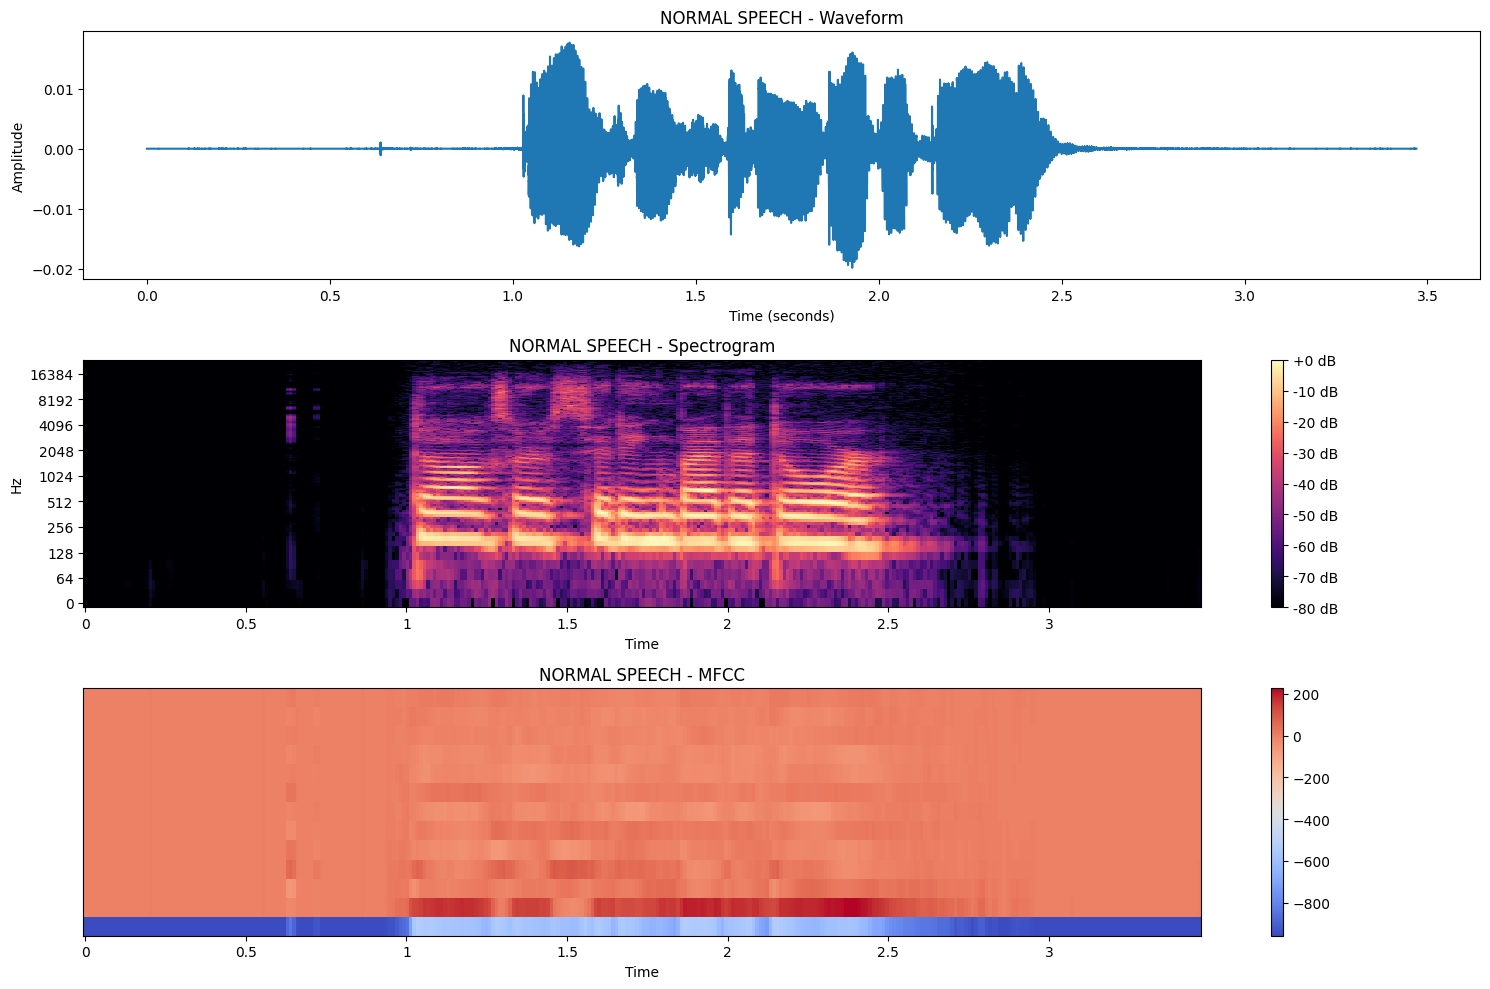

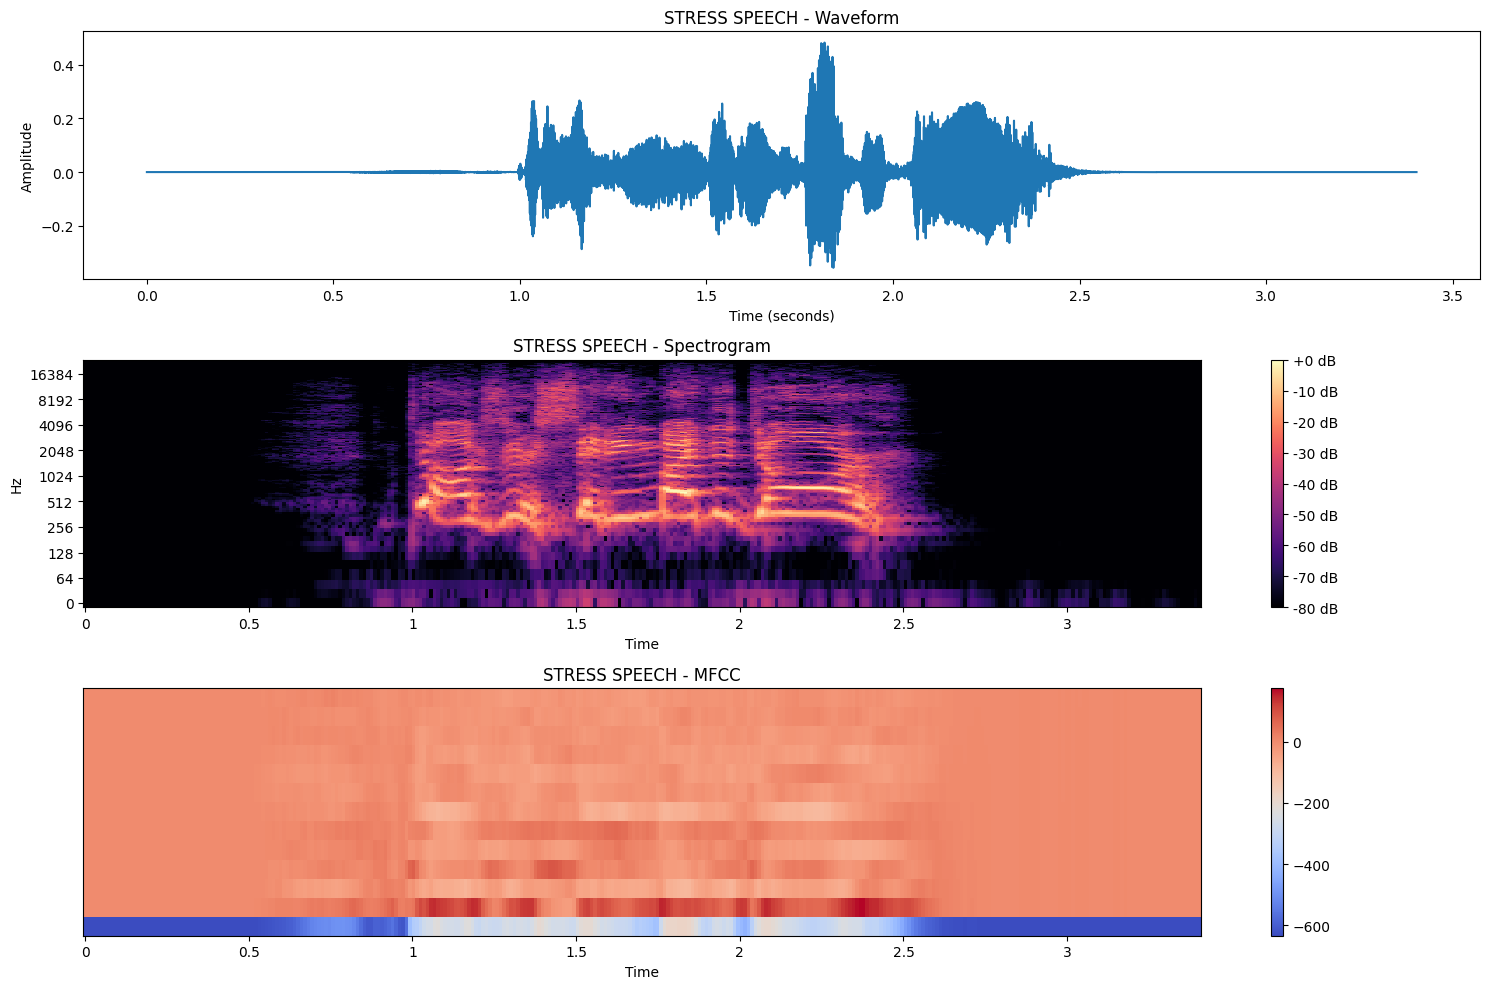

In [ ]:
# -------- Visualization: Stress vs Normal Speech --------

import random

def get_label(file_path):
    filename = os.path.basename(file_path)
    emotion_code = filename.split("-")[2]
    emotion = emotion_dict[emotion_code]
    return stress_map[emotion]


# Separate files into stress and normal
stress_files = []
normal_files = []

for file in audio_files:
    label = get_label(file)
    if label == "stress":
        stress_files.append(file)
    else:
        normal_files.append(file)

# Pick one random sample from each
stress_sample = random.choice(stress_files)
normal_sample = random.choice(normal_files)


def visualize_audio(file_path, title):

    signal, sr = librosa.load(file_path, sr=None)

    plt.figure(figsize=(15,10))

    # ---------------- Waveform ----------------
    plt.subplot(3,1,1)
    time_axis = np.linspace(0, len(signal)/sr, num=len(signal))
    plt.plot(time_axis, signal)
    plt.title(f"{title} - Waveform")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")

    # ---------------- Spectrogram ----------------
    plt.subplot(3,1,2)
    stft = librosa.stft(signal)
    spectrogram_db = librosa.amplitude_to_db(abs(stft), ref=np.max)
    librosa.display.specshow(spectrogram_db,
                             sr=sr,
                             x_axis='time',
                             y_axis='log')
    plt.title(f"{title} - Spectrogram")
    plt.colorbar(format='%+2.0f dB')

    # ---------------- MFCC ----------------
    plt.subplot(3,1,3)
    mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=13)
    librosa.display.specshow(mfcc,
                             sr=sr,
                             x_axis='time')
    plt.title(f"{title} - MFCC")
    plt.colorbar()

    plt.tight_layout()
    plt.show()


# Visualize NORMAL speech
visualize_audio(normal_sample, "NORMAL SPEECH")

# Visualize STRESS speech
visualize_audio(stress_sample, "STRESS SPEECH")

In [ ]:
X = []
y = []

for file in audio_files:
    feat, lab, _ = extract_features(file)
    X.append(feat)
    y.append(lab)

X = np.array(X)
y = np.array(y)

print("Feature shape:", X.shape)

Feature shape: (2880, 17)


In [ ]:
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

print("Classes:", encoder.classes_)

Classes: ['normal' 'stress']


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42
)

In [ ]:
model = RandomForestClassifier(n_estimators=150)
model.fit(X_train, y_train)

predictions = model.predict(X_test)

In [ ]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.97      0.93      0.95       188
           1       0.96      0.98      0.97       388

    accuracy                           0.97       576
   macro avg       0.97      0.96      0.96       576
weighted avg       0.97      0.97      0.97       576



Confusion Matrix:
 [[174  14]
 [  6 382]]


<Figure size 600x600 with 0 Axes>

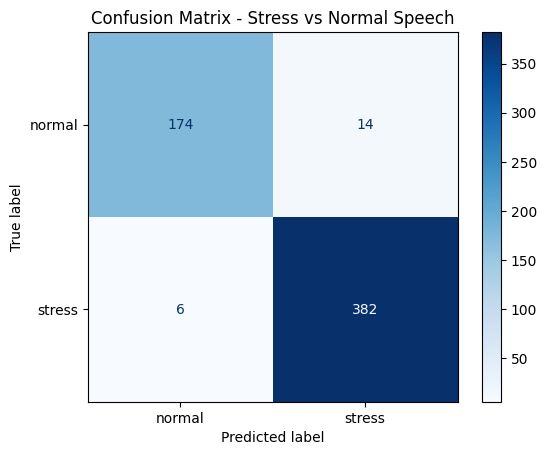

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predict on test data
y_pred = model.predict(X_test)

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:\n", cm)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=encoder.classes_
)

plt.figure(figsize=(6,6))
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix - Stress vs Normal Speech")
plt.show()